In [2]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr



/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
expected_ds = xr.open_dataset('./output/expected_synthetic_data62_2024-11-20.nc')
expected_ds

<xarray.Dataset> Size: 365kB
Dimensions:       (time: 1620, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables: (12/13)
    dcdt(HM)      (time, cutoff) float64 207kB ...
    deadband      (time) int64 13kB ...
    d_intensity   (time) int64 13kB ...
    d_startpoint  (time) int64 13kB ...
    add_noise     (time) bool 2kB ...
    c0            (time) int64 13kB ...
    ...            ...
    cs            (time) float64 13kB ...
    pressure      (time) float64 13kB ...
    temperature   (time) float64 13kB ...
    humidity      (time) float64 13kB ...
    area          (time) float64 13kB ...
    volume        (time) float64 13kB ...

In [5]:
ds = xr.open_dataset('./output/synthetic_data62_2024-11-20.nc')
ds

<xarray.Dataset> Size: 7MB
Dimensions:       (time: 1620, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * deadband      (deadband) int32 24B 0 10 20 30 40 50
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 1MB ...
    dcdt(linear)  (time, cutoff, deadband) float64 1MB ...
    AIC(HM)       (time, cutoff, deadband) float64 1MB ...
    AIC(linear)   (time, cutoff, deadband) float64 1MB ...
    RMSE(HM)      (time, cutoff, deadband) float64 1MB ...
    RMSE(linear)  (time, cutoff, deadband) float64 1MB ...

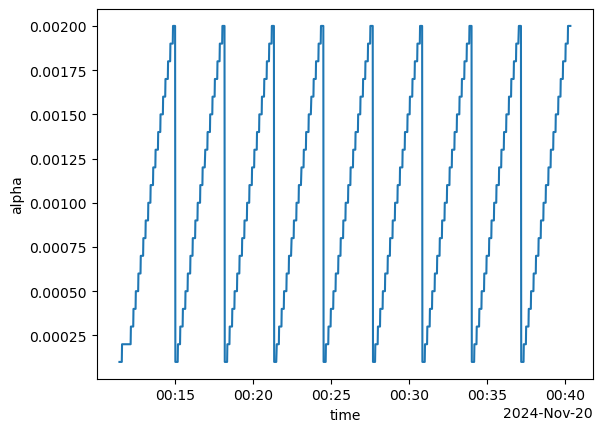

In [6]:
expected_ds['alpha'].plot()

In [7]:
np.unique(expected_ds['d_startpoint'].values)

array([  0,  20,  30,  40,  50,  90, 100, 110, 150])

In [8]:
print(expected_ds)

<xarray.Dataset> Size: 365kB
Dimensions:       (time: 1620, cutoff: 16)
Coordinates:
  * time          (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-...
  * cutoff        (cutoff) int32 64B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables: (12/13)
    dcdt(HM)      (time, cutoff) float64 207kB ...
    deadband      (time) int64 13kB ...
    d_intensity   (time) int64 13kB ...
    d_startpoint  (time) int64 13kB 0 0 0 0 0 0 0 ... 150 150 150 150 150 150
    add_noise     (time) bool 2kB ...
    c0            (time) int64 13kB ...
    ...            ...
    cs            (time) float64 13kB ...
    pressure      (time) float64 13kB ...
    temperature   (time) float64 13kB ...
    humidity      (time) float64 13kB ...
    area          (time) float64 13kB ...
    volume        (time) float64 13kB ...


In [9]:
expected_ds['mdf'] = metrics.minimum_detectable_flux(Aa=30*1000,
                                tc=expected_ds['cutoff'],
                                freq=1,
                                # V=expected_ds['volume']/100e3,
                                # A=expected_ds['area']/100e2,
                                V=np.pi*0.2**2/4*0.2,
                                A=np.pi*0.2**2/4,
                                P=expected_ds['pressure'],
                                T=expected_ds['temperature']+273.15)/1000

In [10]:
expected_ds['e_s'] = models.calculate_saturated_vapor_pressure(expected_ds['temperature'])

In [11]:
expected_ds['X_h2o'] = models.mole_fraction_water_vapor(temperature=expected_ds['temperature'],
                                                        humidity=expected_ds['humidity'],
                                                        pressure=expected_ds['pressure'])

In [12]:
expected_ds['mdf_dcdt'] = models.dcdt_from_soilgasflux(volume=expected_ds['volume'],
                                                       area=expected_ds['area'],
                                                       p0=expected_ds['pressure']/1000,
                                                       w0=expected_ds['X_h2o'],
                                                       t0=expected_ds['temperature'],
                                                       soilgasflux=expected_ds['mdf']
                                                       )

In [13]:
# expected_ds['mdf_dcdt_diff'] = expected_ds['mdf_dcdt'].diff(dim='cutoff', label='upper')
# expected_ds['mdf_dcdt_diff'] = 

In [14]:
expected_ds['mdf_dcdt_change'] = (expected_ds['mdf_dcdt'][:]**2 + expected_ds['mdf_dcdt'][1:]**2)**(1/2)

In [15]:
expected_ds['mdf_dcdt_change']

<xarray.DataArray 'mdf_dcdt_change' (cutoff: 16, time: 1620)> Size: 207kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.25821753, 0.25821753, 0.25821753, ..., 0.25821753, 0.25821753,
        0.25821753],
       [0.1677172 , 0.1677172 , 0.1677172 , ..., 0.1677172 , 0.1677172 ,
        0.1677172 ],
       ...,
       [0.02309568, 0.02309568, 0.02309568, ..., 0.02309568, 0.02309568,
        0.02309568],
       [0.02096465, 0.02096465, 0.02096465, ..., 0.02096465, 0.02096465,
        0.02096465],
       [0.0191423 , 0.0191423 , 0.0191423 , ..., 0.0191423 , 0.0191423 ,
        0.0191423 ]])
Coordinates:
  * time     (time) datetime64[ns] 13kB 2024-11-20T00:11:27 ... 2024-11-20T00...
  * cutoff   (cutoff) int32 64B 20 30 40 50 60 70 80 ... 120 130 140 150 160 170

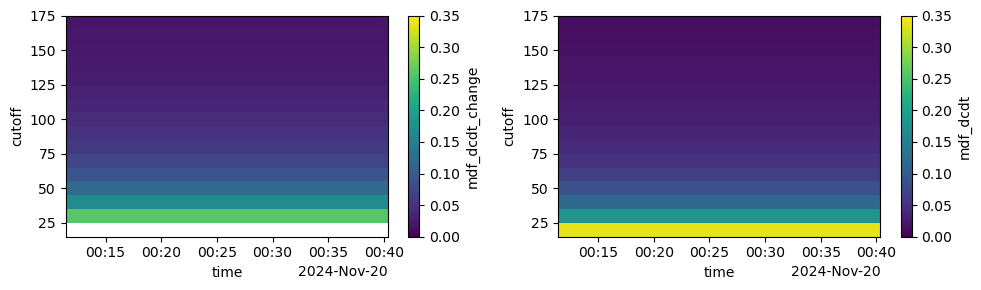

In [16]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
expected_ds['mdf_dcdt_change'].plot(ax=ax[0],vmin=0, vmax=0.35)
expected_ds['mdf_dcdt'].plot(ax=ax[1], vmin=0, vmax=0.35)
fig.tight_layout()


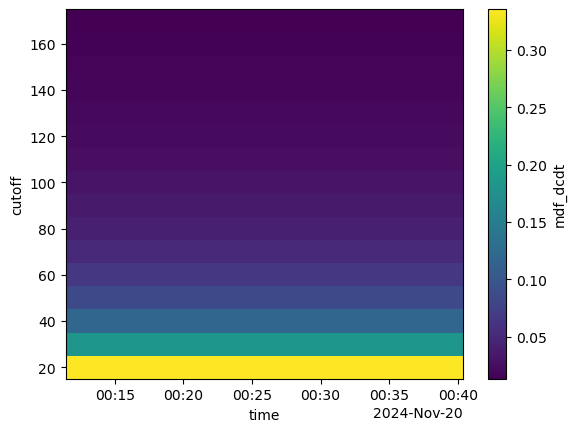

In [17]:
expected_ds['mdf_dcdt'].plot()

In [18]:
np.unique(expected_ds['d_startpoint'].values)

array([  0,  20,  30,  40,  50,  90, 100, 110, 150])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


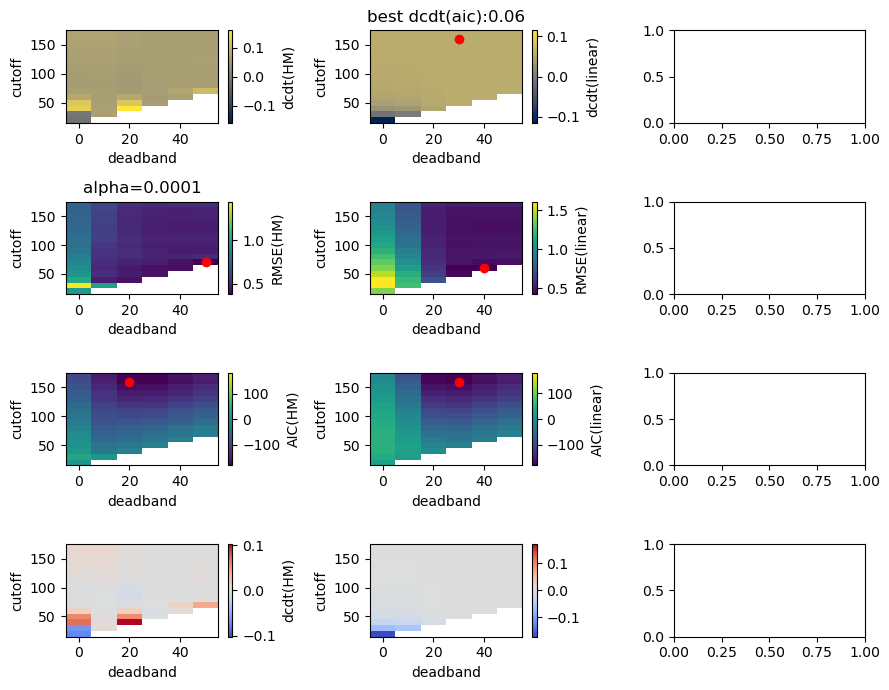

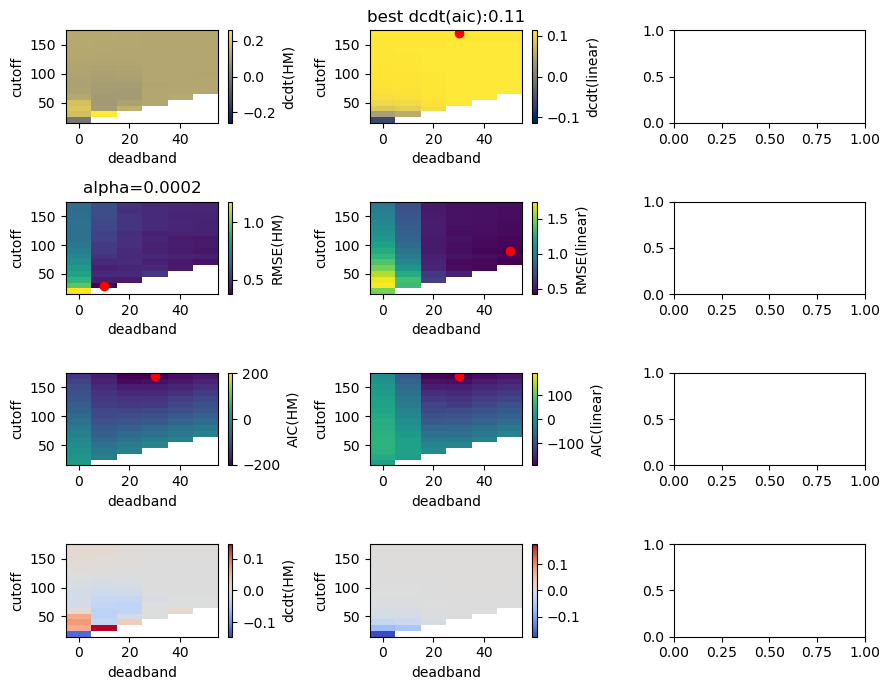

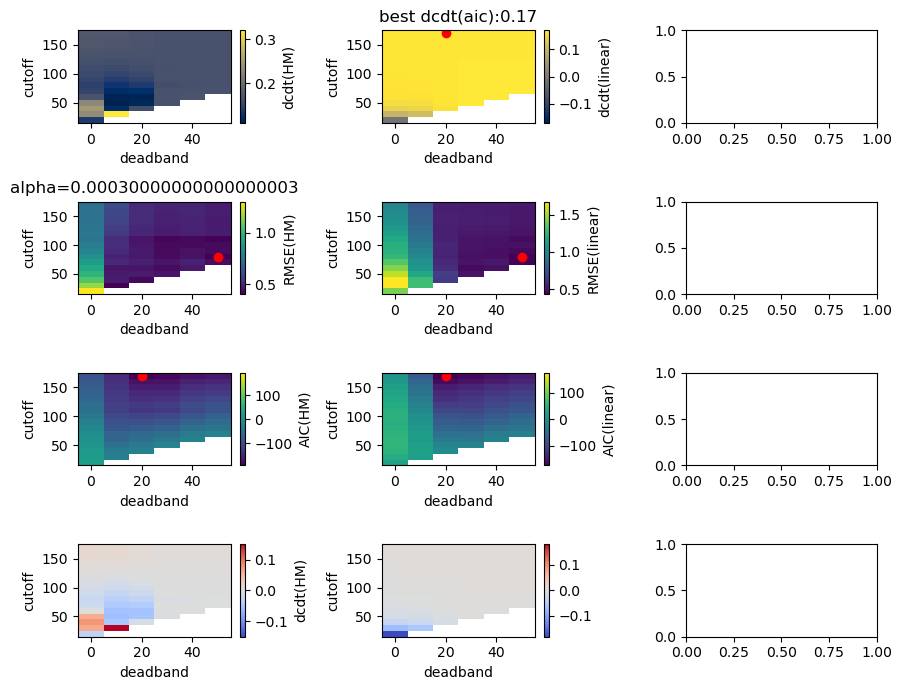

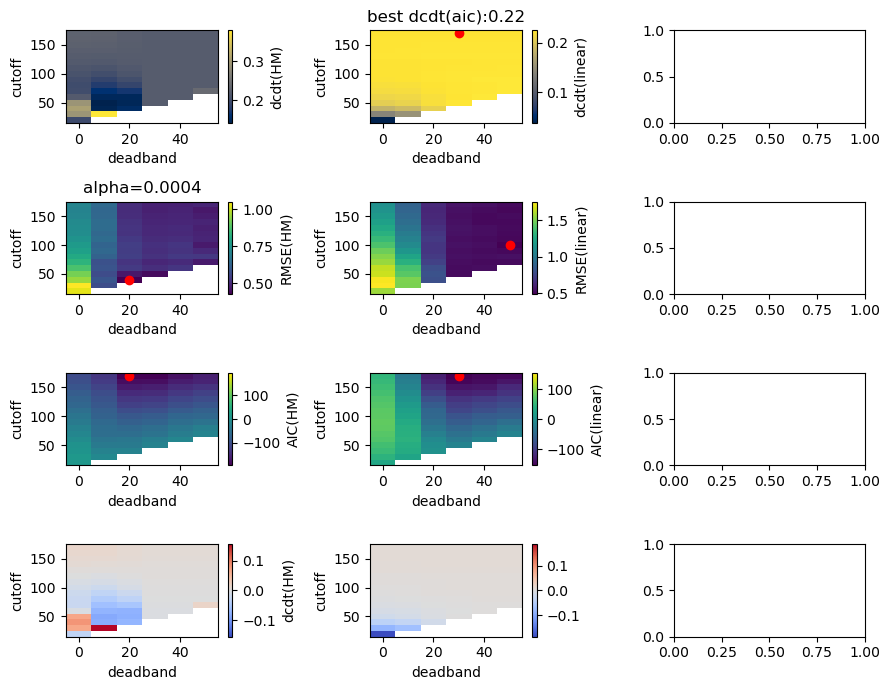

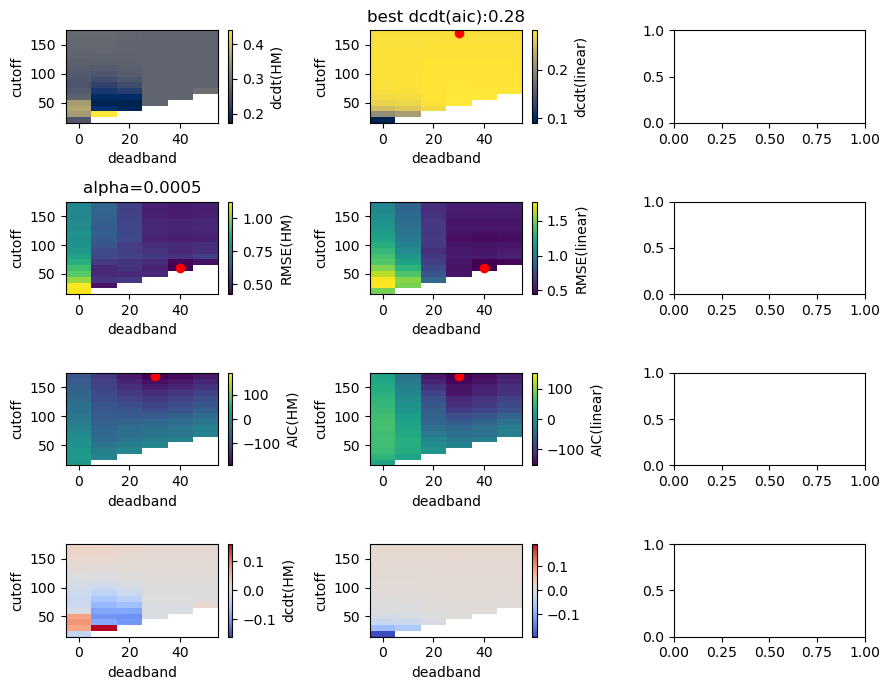

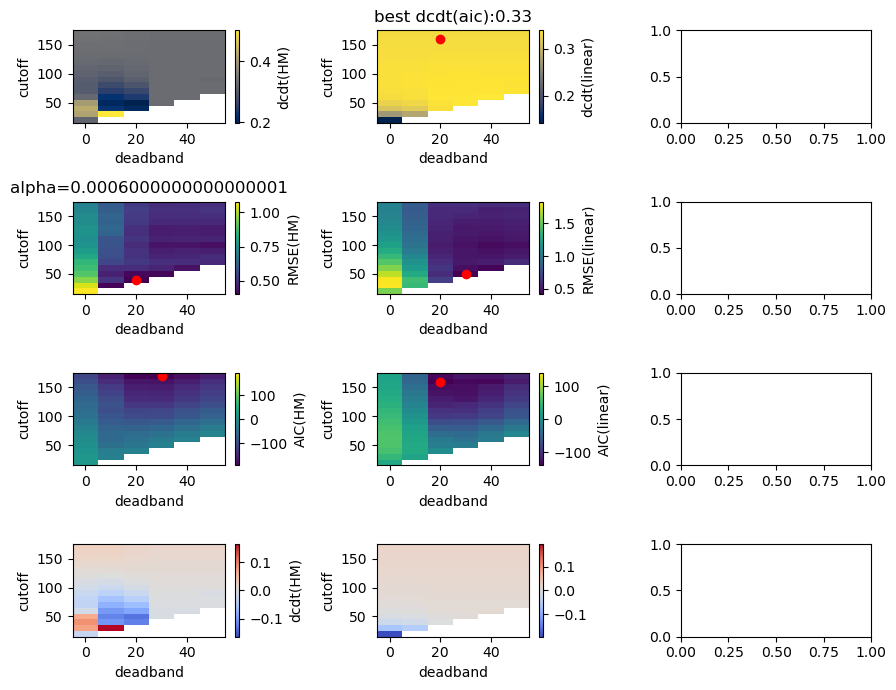

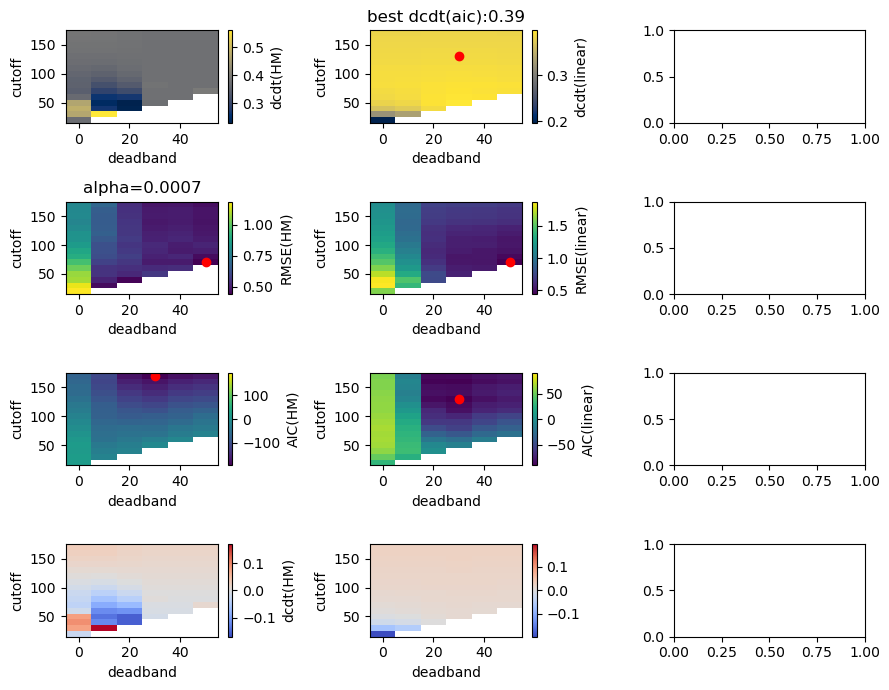

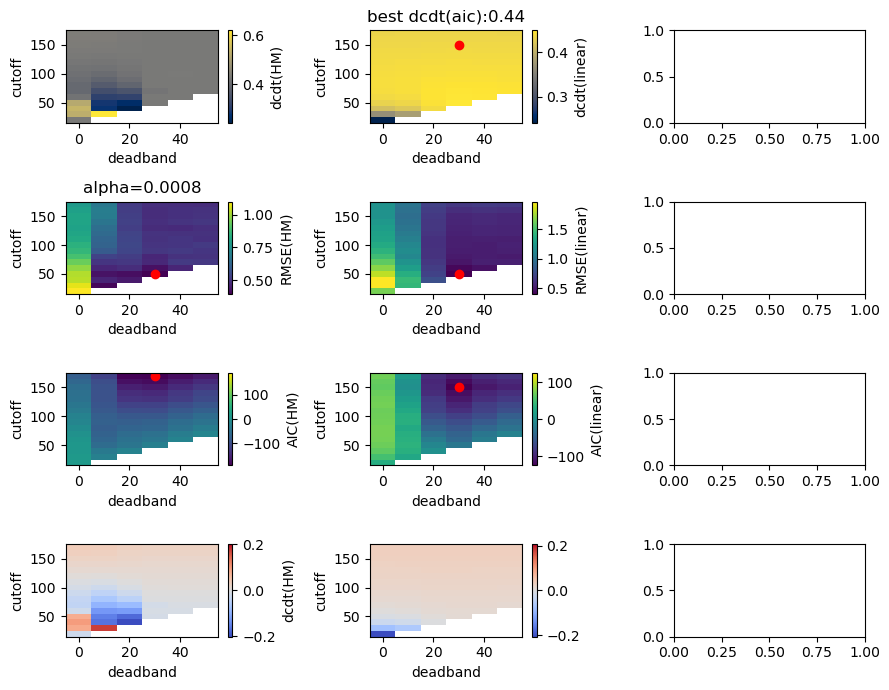

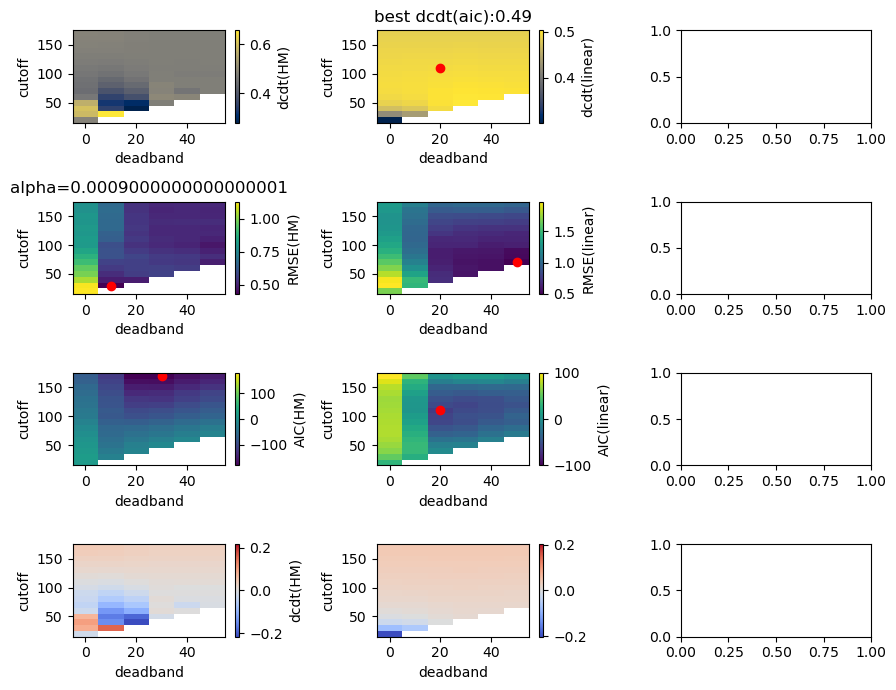

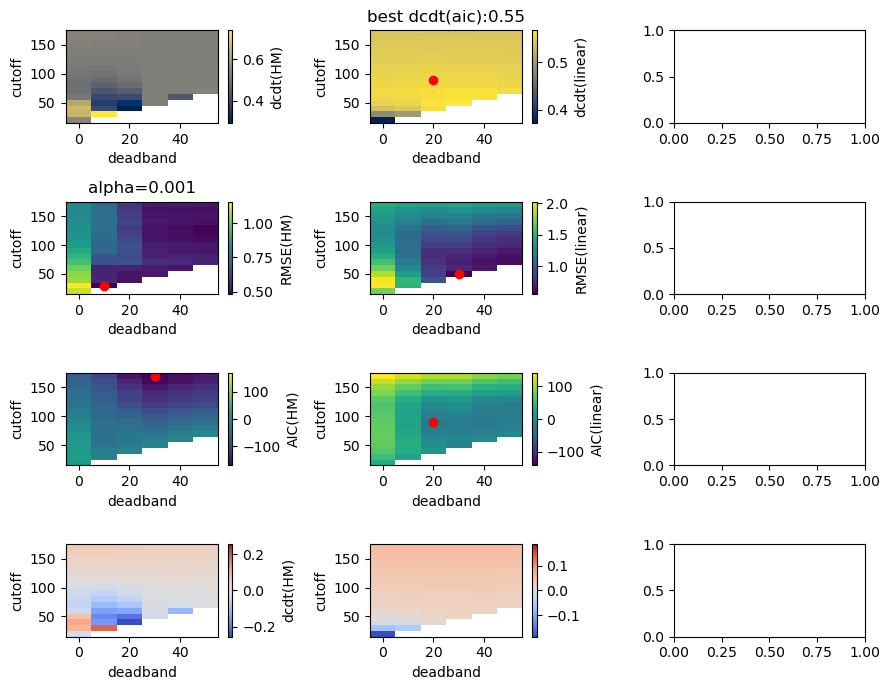

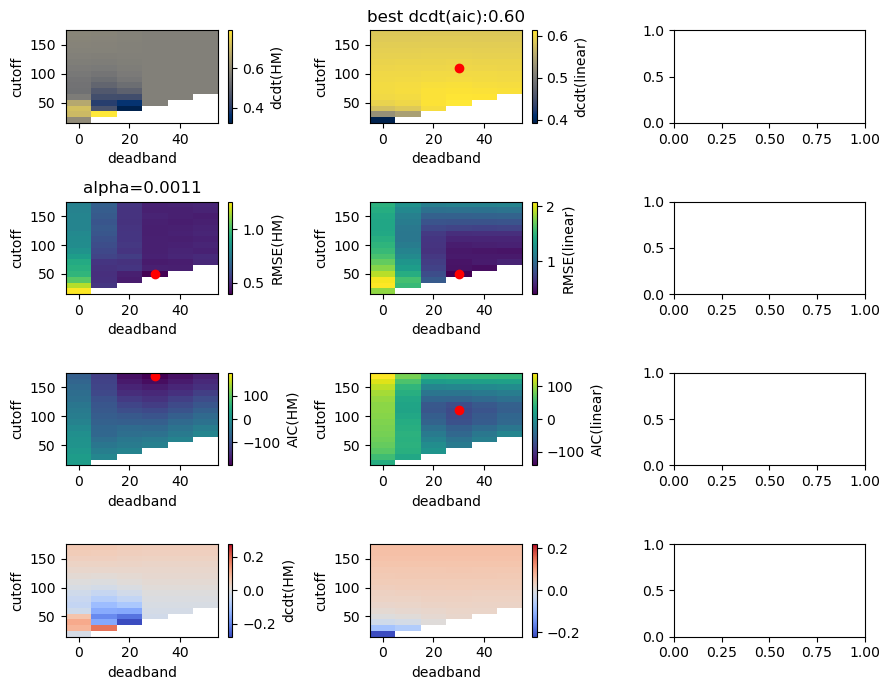

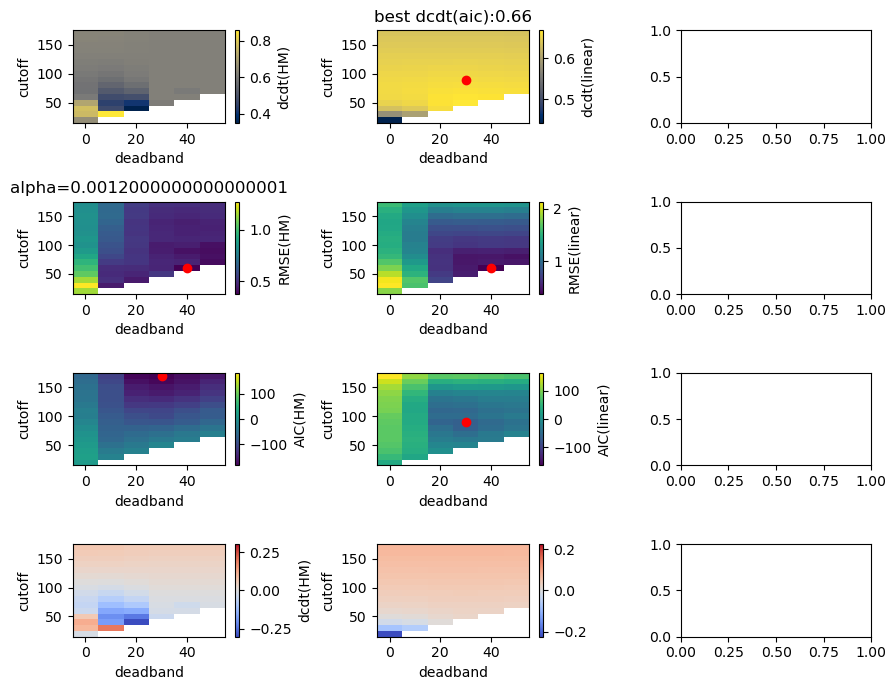

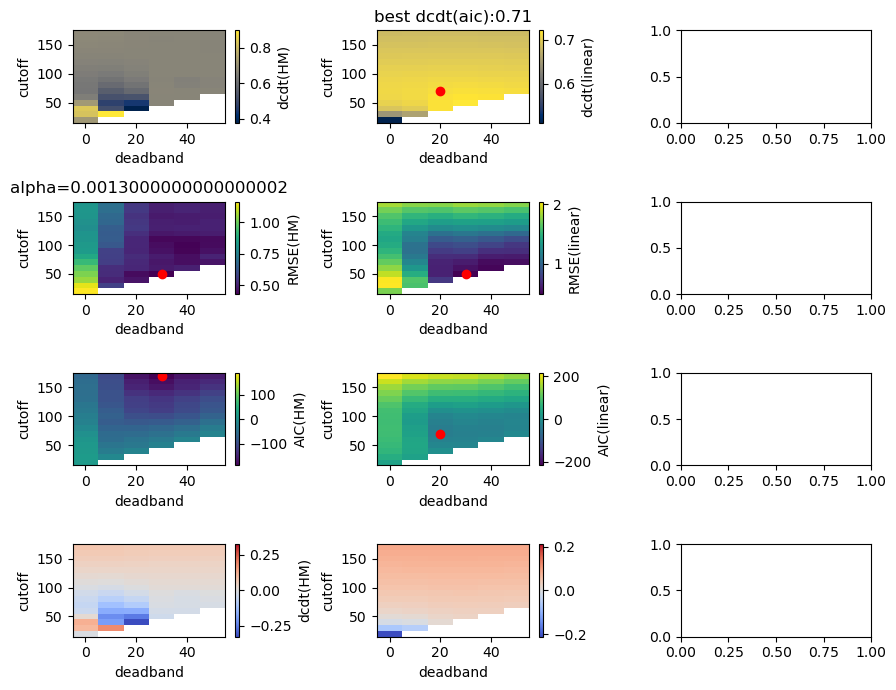

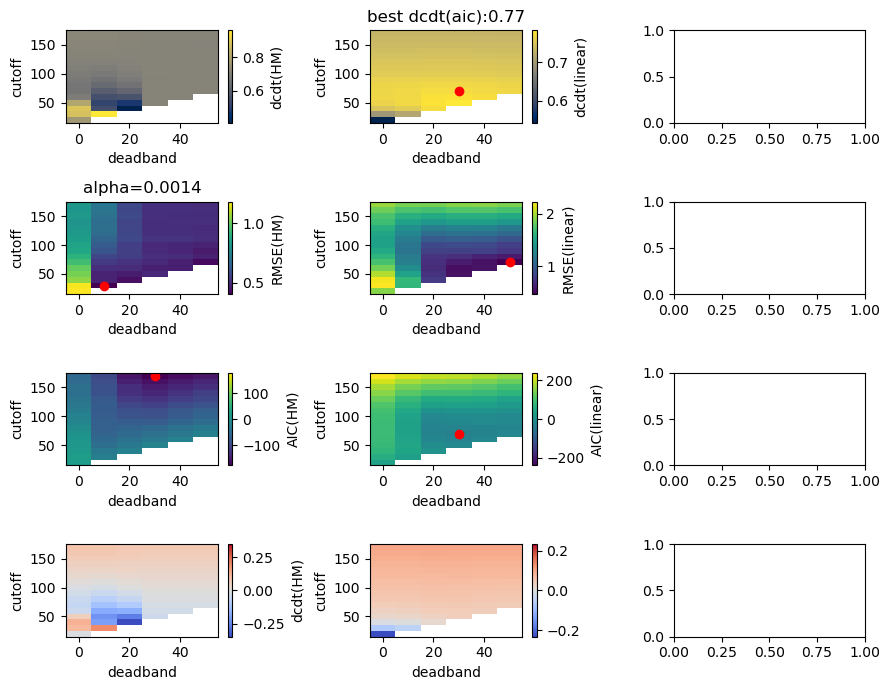

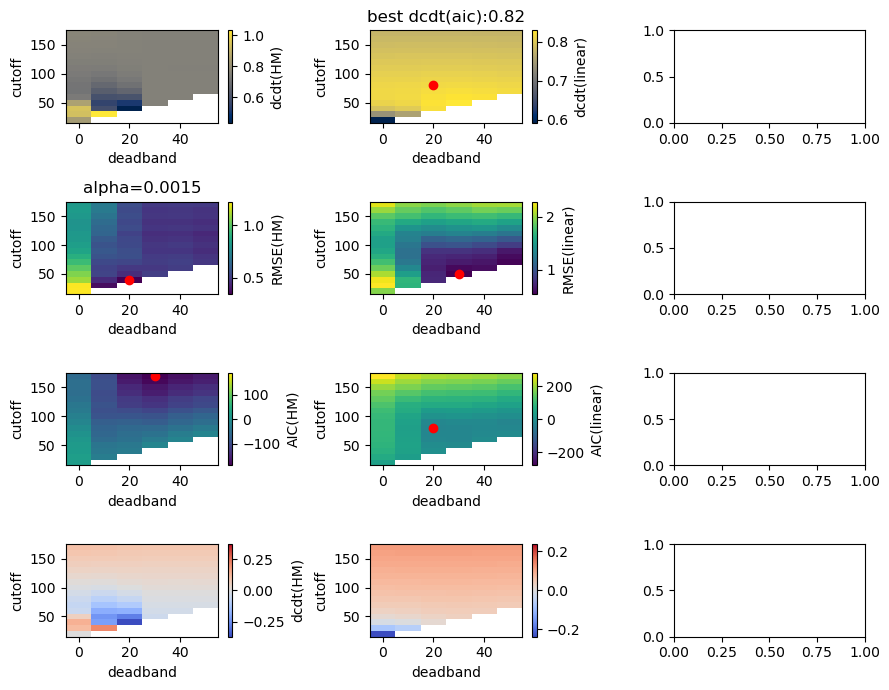

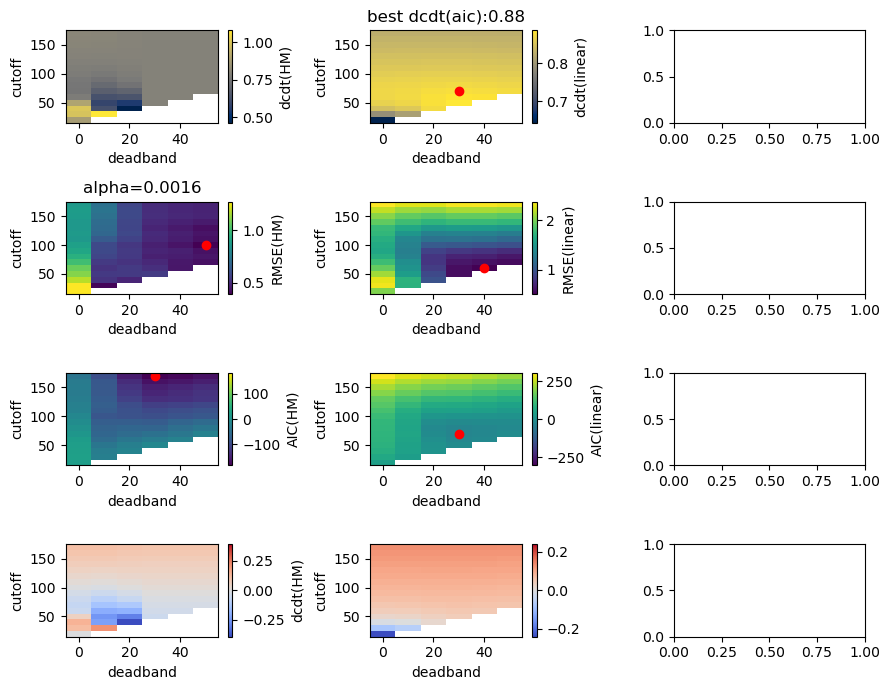

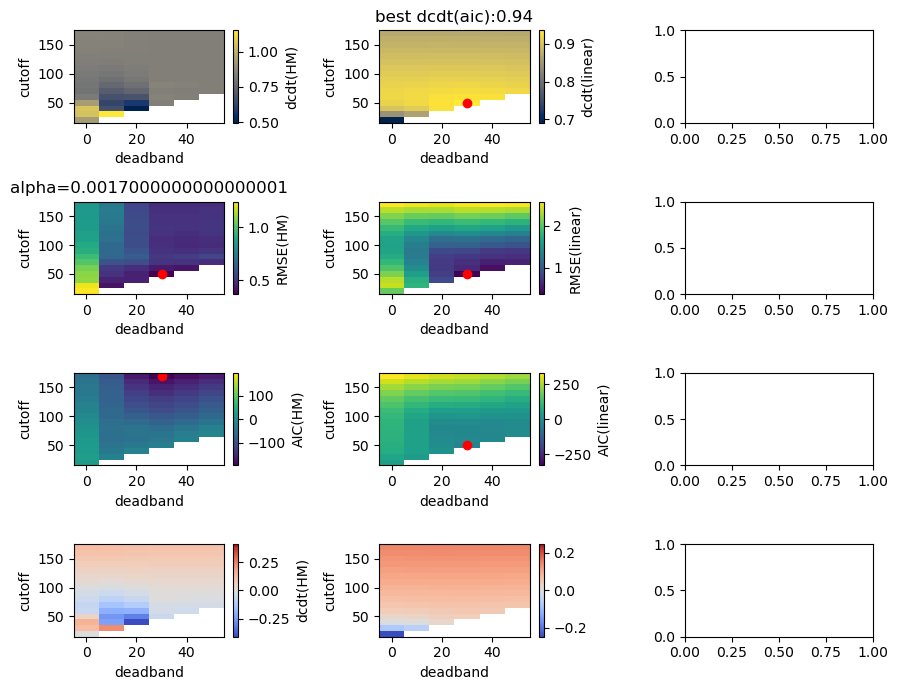

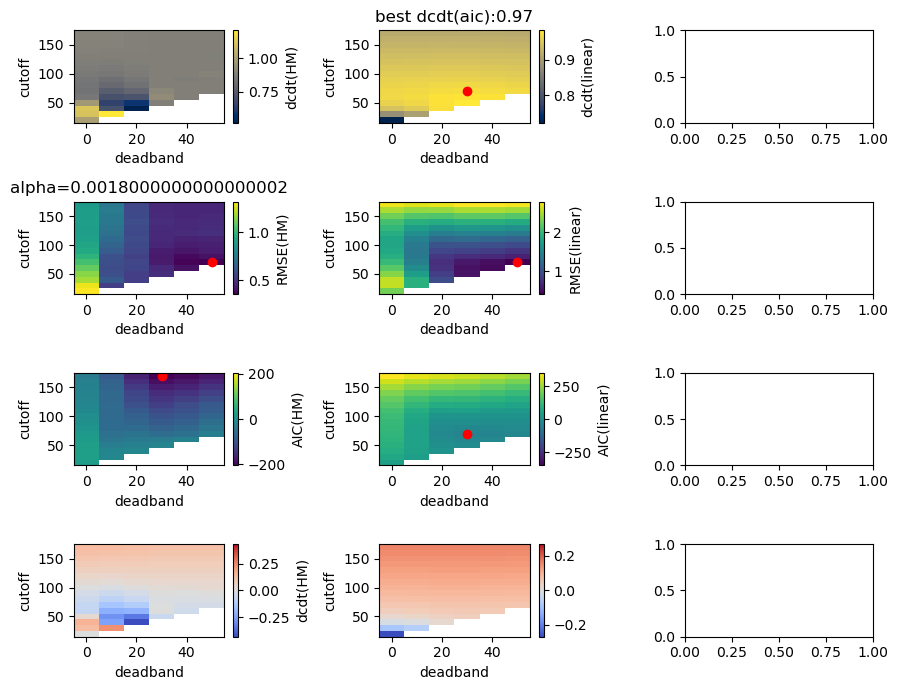

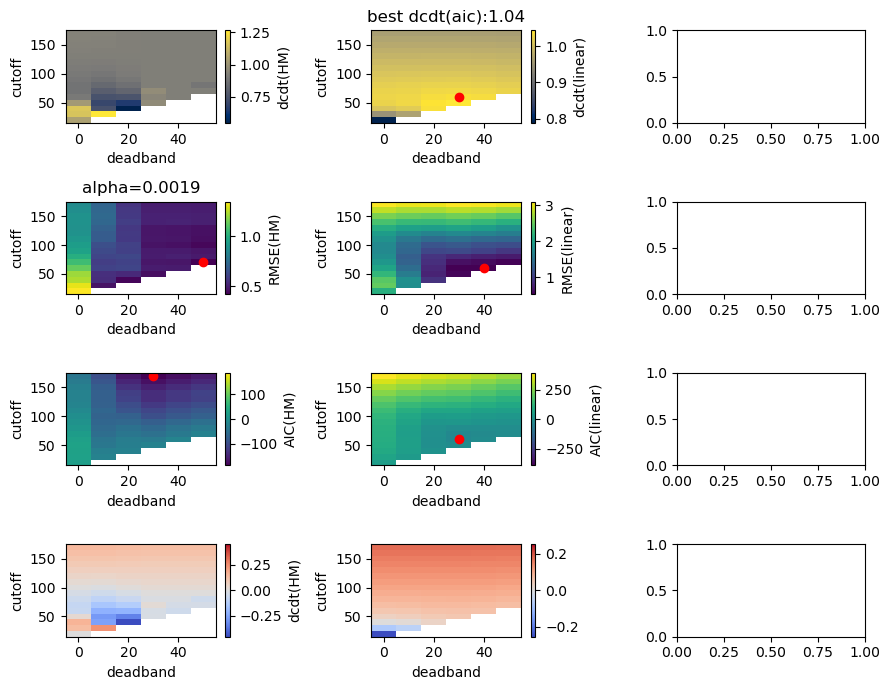

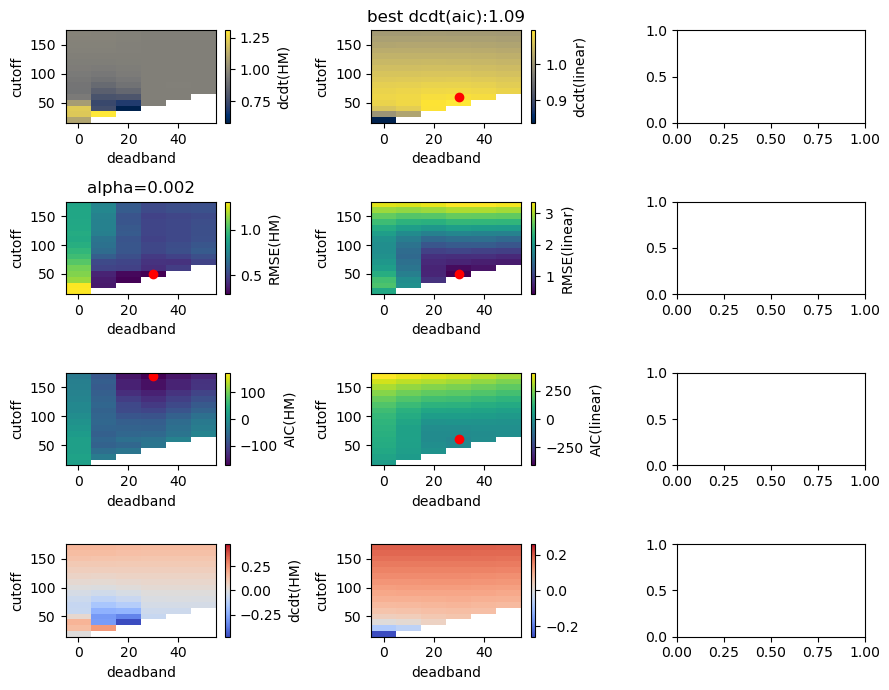

In [19]:
for alpha in np.unique(expected_ds['alpha'].values):
    # print(d_startpoint)
    # d_startpoint = 20

    fig, ax = plt.subplots(4,2, figsize=(9,7))
    
    time_selection = expected_ds.where((expected_ds['alpha'] == alpha)&(expected_ds['d_startpoint']==150), drop=True).time
    cutoff_coords, deadband_coords = ds.coords['cutoff'], ds.coords['deadband']

    ds.sel(time=time_selection)['dcdt(HM)'].median(dim=['time']).plot(ax=ax[0,0], cmap='cividis')
    ds.sel(time=time_selection)['dcdt(linear)'].median(dim=['time']).plot(ax=ax[0,1], cmap='cividis')


    ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).plot(ax=ax[1,0], cmap='viridis')
    ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).plot(ax=ax[1,1], cmap='viridis')

    ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).plot(ax=ax[2,0], cmap='viridis')
    ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).plot(ax=ax[2,1], cmap='viridis')

    # ax[2,0].scatter(ds.sel(time=time_selection)['AIC(HM)'].argmin(dim=['time']), ds.sel(time=time_selection)['AIC(HM)'].min(dim=['time']), color='red')
    # ax[2,0].scatter(20,100, color='red')
    
    aic_argmin_HM = ds.sel(time=time_selection)['AIC(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    aic_argmin_linear = ds.sel(time=time_selection)['AIC(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])

    rmse_argmin_HM = ds.sel(time=time_selection)['RMSE(HM)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])
    rmse_argmin_linear = ds.sel(time=time_selection)['RMSE(linear)'].median(dim=['time']).argmin(dim=['cutoff', 'deadband'])

    

    ax[2,0].scatter(deadband_coords[aic_argmin_HM['deadband']], 
                    cutoff_coords[aic_argmin_HM['cutoff']], color='red')
    ax[2,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    ax[1,0].scatter(deadband_coords[rmse_argmin_HM['deadband']],
                    cutoff_coords[rmse_argmin_HM['cutoff']], color='red')
    ax[1,1].scatter(deadband_coords[rmse_argmin_linear['deadband']],
                    cutoff_coords[rmse_argmin_linear['cutoff']], color='red')


    (ds.sel(time=time_selection)['dcdt(HM)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,0], cmap='coolwarm')
    (ds.sel(time=time_selection)['dcdt(linear)']-expected_ds.sel(time=time_selection)['dcdt(HM)']).median(dim=['time']).plot(ax=ax[3,1], cmap='coolwarm')

    ax[0,1].scatter(deadband_coords[aic_argmin_linear['deadband']],
                    cutoff_coords[aic_argmin_linear['cutoff']], color='red')
    
    
    dcdt_linear_minAIC = ds.sel(time=time_selection, 
                                deadband=deadband_coords[aic_argmin_linear['deadband']],
                                cutoff=cutoff_coords[aic_argmin_linear['cutoff']])['dcdt(linear)'].median(dim=['time']).values
    
    ax[0,1].set_title(f'best dcdt(aic):{dcdt_linear_minAIC:.2f}')


    ax[1,0].set_title(f'alpha={alpha}')
    fig.tight_layout()
    fig.show()
    # break